# Tailoring metabolic networks (future release)

In [2]:
ijn.objective.expression

1.0*BIOMASS_KT_TEMP - 1.0*BIOMASS_KT_TEMP_reverse_d18f7

In [10]:
blocked_reactions = [reac for reac in ijn.reactions][1:20]
blocked_reactions

[<Reaction 3OAR141 at 0x763ca5ba30d0>,
 <Reaction EX_glyald_e at 0x763ca5ba3490>,
 <Reaction 3OAR160 at 0x763ca5ba3a90>,
 <Reaction 3OAR161 at 0x763ca5ba36d0>,
 <Reaction 3OAR180 at 0x763ca5ba3fd0>,
 <Reaction 3OAR181 at 0x763ca5ba3520>,
 <Reaction ACS at 0x763ca5a00280>,
 <Reaction ACt2rpp at 0x763ca5a00160>,
 <Reaction 3OAR40 at 0x763ca5a01150>,
 <Reaction EX_cit_e at 0x763ca5a01180>,
 <Reaction EX_co2_e at 0x763ca5ba3cd0>,
 <Reaction 3OAR60 at 0x763ca5ba3700>,
 <Reaction 3OAR80 at 0x763ca5ba3910>,
 <Reaction 3OAS100 at 0x763ca5a02020>,
 <Reaction 3OAS120 at 0x763ca5a01ba0>,
 <Reaction 3OAS121 at 0x763ca5a02920>,
 <Reaction ACtex at 0x763ca5a02c80>,
 <Reaction 3OAS140 at 0x763ca5ba3ee0>,
 <Reaction ADA at 0x763ca5a02620>]

In [6]:
ijn.remove_reactions([ijn.reactions[4]])

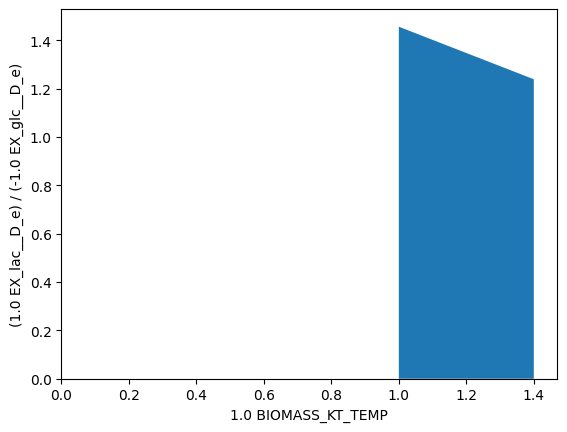

INFO:root:Preparing strain design computation.
INFO:root:  Using random seed 47927
INFO:root:  Using cplex for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (739 genes, 808 gpr rules).
INFO:root:  Simplifyied to 539 genes and 517 gpr rules.
INFO:root:  Extending metabolic network with gpr associations.
/home/pschneider/miniconda3/envs/cnapy-1.2.4/lib/python3.10/site-packages/cobra/core/reaction.py:1567: UserWarning: no model found
  warn("no model found")
INFO:root:Compressing Network (1926 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 743 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Reduced to 696 reaction

IndexError: list index out of range

In [7]:
import straindesign as sd
import cobra

cobra.Configuration().solver = 'cplex'
ijn = cobra.io.load_model('iJN746') # or  iJN1463

# exchange_reacs = [r for r in ijn.reactions if all(s<0 for s in r.metabolites.values())]
# # shut all exchange fluxes
# for r in exchange_reacs:
#     r.upper_bound = 0.0

# # shut CO2 uptake
# ijn.reactions.EX_co2_e.lower_bound    = 0.0
ijn.reactions.BIOMASS_KT_TEMP           = 0.0

# # keep main fermentation products open
# ijn.reactions.EX_ac_e.upper_bound     = 1000.0
# ijn.reactions.EX_co2_e.upper_bound    = 1000.0
# ijn.reactions.EX_etoh_e.upper_bound   = 1000.0
# ijn.reactions.EX_for_e.upper_bound    = 1000.0
# ijn.reactions.EX_h2o2_e.upper_bound   = 1000.0
# ijn.reactions.EX_h2o_e.upper_bound    = 1000.0
# ijn.reactions.EX_h_e.upper_bound      = 1000.0
# ijn.reactions.EX_lac__D_e.upper_bound = 1000.0
# ijn.reactions.EX_meoh_e.upper_bound   = 1000.0
# ijn.reactions.EX_o2_e.upper_bound     = 1000.0
# ijn.reactions.EX_succ_e.upper_bound   = 1000.0
# ijn.reactions.EX_tungs_e.upper_bound  = 1000.0

# for r in ijn.reactions:
#     if 'DM_' in r.id:
#         r.upper_bound = 1000.0
        
atps_genes = [g for g in ijn.reactions.ATPS4rpp.genes]
ijn.reactions.ATPS4rpp.gene_reaction_rule = str(atps_genes[0])
cobra.manipulation.remove_genes(ijn,atps_genes[1:])
atps_genes[0].name = 'atpX'

min_lac_yield = 0.2
min_growth = 0.05
module_suppress = sd.SDModule(ijn,sd.SUPPRESS,constraints=f'EX_lac__D_e + {min_lac_yield} EX_glc__D_e <= 0')
module_protect  = sd.SDModule(ijn,sd.PROTECT, constraints=f'BIOMASS_KT_TEMP>={min_growth}')

sd.plot_flux_space(ijn, ('BIOMASS_KT_TEMP',('EX_lac__D_e','-EX_glc__D_e')));

import logging
logging.basicConfig(level=logging.INFO)

# allow all gene knockouts except for spontanuos 
gko_cost = {g.id:1 for g in ijn.genes}    
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# Compute strain designs
sols = sd.compute_strain_designs(ijn,
                                 sd_modules = [module_suppress, module_protect],
                                 max_solutions = 1,
                                 max_cost = 40,
                                 ko_cost = ko_cost,
                                 gko_cost = gko_cost,
                                 solution_approach = sd.ANY)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.reaction_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")


import matplotlib.pyplot as plt
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ijn,
                                               ('BIOMASS_KT_TEMP',('EX_lac__D_e','-EX_glc__D_e')),
                                               show=False);
_,          _,      plot2 = sd.plot_flux_space(ijn,
                                               ('BIOMASS_KT_TEMP',('EX_lac__D_e','-EX_glc__D_e')),
                                               constraints=f'BIOMASS_KT_TEMP>={min_growth}',
                                               show=False);
plot2.set_facecolor('#70AD47')
plot2.set_edgecolor('#70AD47')
# pGCP design plot
_,          _,      plot3 = sd.plot_flux_space(ijn,
                                               ('BIOMASS_KT_TEMP',('EX_lac__D_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=f'EX_lac__D_e + {min_lac_yield} EX_glc__D_e <= 0',
                                               show=False);
plot3.set_facecolor('#ED7D31')
plot3.set_edgecolor('#ED7D31')
# plotting designed strain
interventions = [[{s:1.0},'=',0.0] for s,v in sols.reaction_sd[0].items() if v < 1]
_,          _,      plot4 = sd.plot_flux_space(ijn,
                                               ('BIOMASS_KT_TEMP',('EX_lac__D_e','-EX_glc__D_e')),
                                               # The sign of the glucose exchange reaction is flipped since 
                                               # reaction is defined in the direction of secretion.
                                               constraints=interventions,
                                               show=False);
plot4.set_facecolor('#FFC000')
plot4.set_edgecolor('#FFC000')
# adjust axes limits and show plot
plot4.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot4.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

Continued ..

## Carving

## Gap-filling